<a href="https://colab.research.google.com/github/ixomaxip/nasoc/blob/master/tf_prepare_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture

!pip install nltk emoji
!pip install tweet-preprocessor

!pip install transformers
!pip install datasets

!wget https://hasocfire.github.io/hasoc/2021/files/en_Hasoc2021_train.zip
!unzip -P hasoc2021_en en_Hasoc2021_train.zip
!ls

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import os
import datetime
import re

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

#constants and parameters
seed = 42

path_gdrive_saved = '/content/drive/My Drive/nasoc/bert_tuned.weights'

batch_size = 8

DOWNLOAD_DATASET = False

raw_dataset = pd.read_csv('en_Hasoc2021_train.csv')

raw_dataset['inputs'] = pd.Categorical(raw_dataset['task_1'])
raw_dataset['inputs'] = raw_dataset.inputs.cat.codes

raw_dataset['task_2_cat'] = pd.Categorical(raw_dataset['task_2'])
raw_dataset['task_2_cat'] = raw_dataset.task_2_cat.cat.codes

train_df, test_df = train_test_split(raw_dataset, test_size=0.2, random_state=seed)

sr_train = train_df.groupby('task_1').count()['text']
sr_test  = test_df.groupby('task_1').count()['text']

tr_pr = sr_train['NOT']/sr_train['HOF']
ts_pr = sr_test['NOT']/sr_test['HOF']

#copied from https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

# copied from https://stackoverflow.com/questions/64719706/cleaning-twitter-data-pandas-python
def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    #tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI) #Remove Emojis
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = " ".join(tweet.split())
    tweet = remove_emojis(tweet)
    #tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) \
    #     if w.lower() in words or not w.isalpha())
    return tweet


train_df, test_df = train_test_split(raw_dataset, test_size=0.2, random_state=seed)
text = train_df.pop('text')#.map(lambda line: cleaner(line))
label = train_df.pop('inputs')

text_val = test_df.pop('text')#.map(lambda line: cleaner(line))
label_val = test_df.pop('inputs')

train_ds = tf.data.Dataset.from_tensor_slices((text.values, label.values))
val_ds = tf.data.Dataset.from_tensor_slices((text_val.values, label_val.values))

train_ds = train_ds.batch(batch_size=batch_size, drop_remainder=True)
val_ds = val_ds.batch(batch_size=batch_size, drop_remainder=True)

Downloading:   0%|          | 0.00/843k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


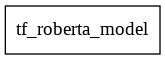

In [3]:
from transformers import TFAutoModel
from transformers import BertweetTokenizer

tokenizer = BertweetTokenizer.from_pretrained("vinai/bertweet-base", normalization=True)
#bertweet = TFAutoModel.from_pretrained("vinai/bertweet-base")

In [7]:
train_df, test_df = train_test_split(raw_dataset, test_size=0.2, random_state=seed)
train_df['input_ids'] = train_df.text.map(lambda line: tokenizer.encode(line, return_tensors='tf'))
label = train_df.inputs

text = train_df['input_ids']#.map(lambda x: tf.reshape(x, [-1]).numpy()).to_numpy()
print(text)

#print(text.to_numpy())

# text_val = test_df.text#.map(lambda line: tokenizer.encode(line))
# label_val = test_df.inputs

train_ds = tf.data.Dataset.from_tensor_slices((text, tf.convert_to_tensor(label)))
# val_ds = tf.data.Dataset.from_tensor_slices((text_val.values, label_val.values))

# train_ds = train_ds.batch(batch_size=batch_size, drop_remainder=True)
# val_ds = val_ds.batch(batch_size=batch_size, drop_remainder=True)

1972    ((tf.Tensor(0, shape=(), dtype=int32), tf.Tens...
3374    ((tf.Tensor(0, shape=(), dtype=int32), tf.Tens...
2424    ((tf.Tensor(0, shape=(), dtype=int32), tf.Tens...
433     ((tf.Tensor(0, shape=(), dtype=int32), tf.Tens...
816     ((tf.Tensor(0, shape=(), dtype=int32), tf.Tens...
                              ...                        
1130    ((tf.Tensor(0, shape=(), dtype=int32), tf.Tens...
1294    ((tf.Tensor(0, shape=(), dtype=int32), tf.Tens...
860     ((tf.Tensor(0, shape=(), dtype=int32), tf.Tens...
3507    ((tf.Tensor(0, shape=(), dtype=int32), tf.Tens...
3174    ((tf.Tensor(0, shape=(), dtype=int32), tf.Tens...
Name: input_ids, Length: 3074, dtype: object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


ValueError: ignored